In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from math import sqrt
import math  
import sklearn.metrics
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from sklearn.base import BaseEstimator, TransformerMixin
import statsmodels.api as sm
import pickle

In [2]:
co2 = pd.read_excel('CO2 dataset.xlsx',parse_dates=['Year'])
co2.set_index(['Year'],inplace=True)

In [3]:
co2

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542
...,...
2010-01-01,15.60000
2011-01-01,15.60000
2012-01-01,14.80000


As we can see that the maximum value is only 18.2 and there is data cocnetrated around that values as well we are not going to do outlier treatment for our model 

In [4]:
min_idx = co2['CO2'].idxmin()
max_idx = co2['CO2'].idxmax()

print("Row with minimum CO2 value:")
print(co2.loc[min_idx])

print("Row with maximum CO2 value:")
print(co2.loc[max_idx])

Row with minimum CO2 value:
CO2    0.00175
Name: 1845-01-01 00:00:00, dtype: float64
Row with maximum CO2 value:
CO2    18.2
Name: 1979-01-01 00:00:00, dtype: float64


Text(0.5, 1.0, 'CO2 Emissions')

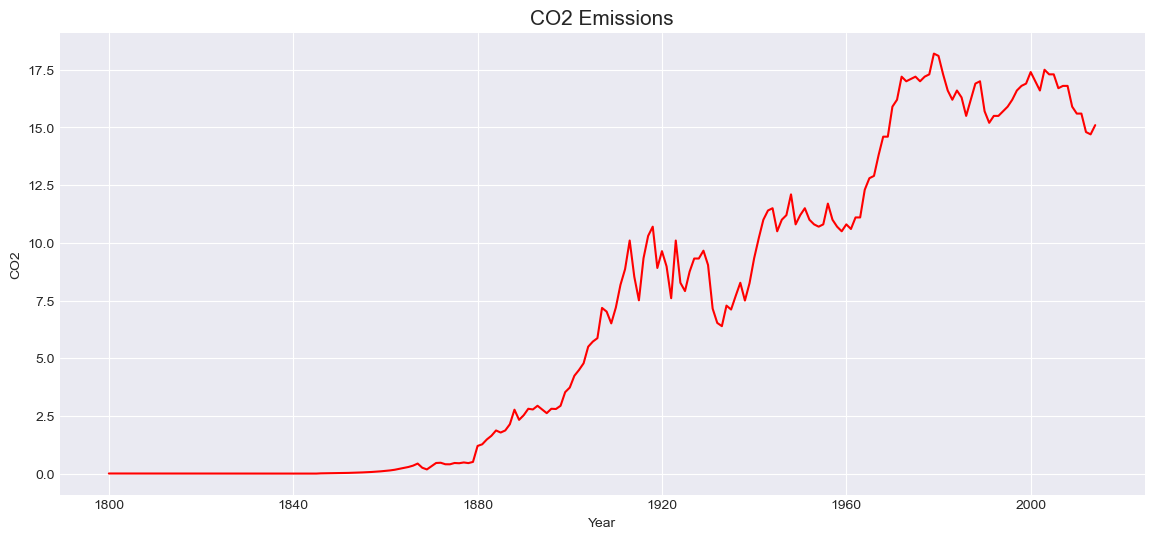

In [5]:
plt.figure(figsize=(14,6))
sns.lineplot(data=co2["CO2"], color='red')
plt.title('CO2 Emissions', fontsize=15)

From the year 1800-1900 the co2 emission is below 2.5

We can clearly see that the co2 emission drastically start increasing after the year 1878

Our Dataset clearly follows an upward trend 

Text(0.5, 1.0, 'CO2 Emissions')

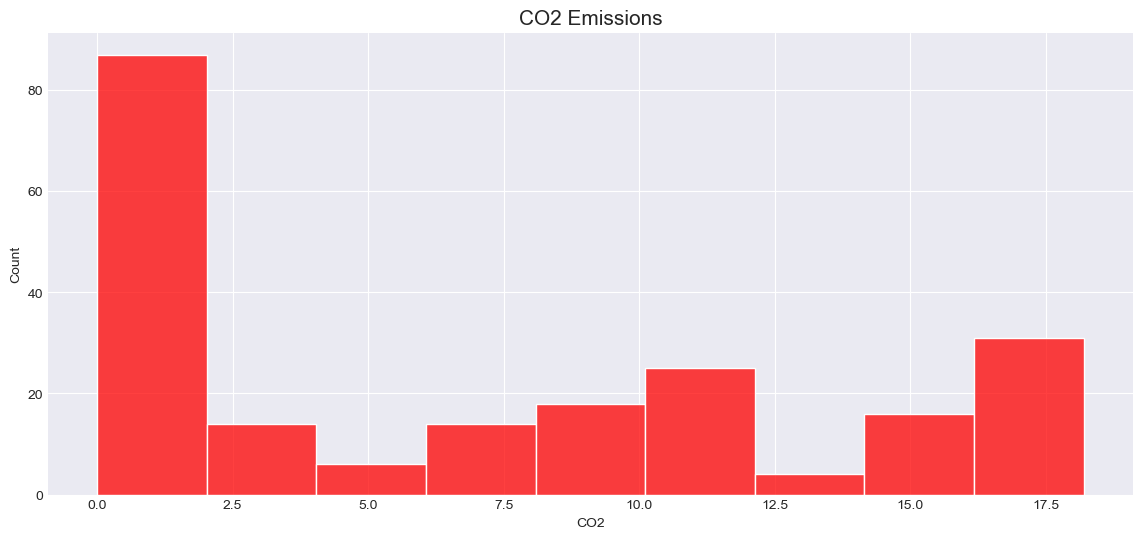

In [6]:
plt.figure(figsize=(14,6))
sns.histplot(data=co2["CO2"], color='red')
plt.title('CO2 Emissions', fontsize=15)

Most number of entries in our dataset is below 2.5

Text(0.5, 1.0, 'Distribution of CO2 Levels')

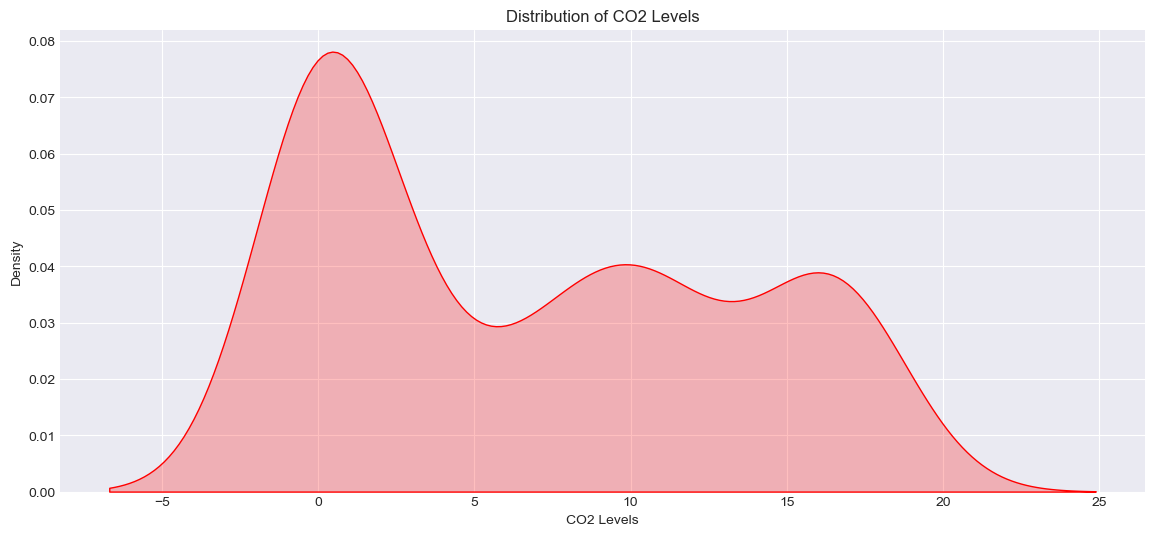

In [7]:
plt.figure(figsize=(14,6))
sns.kdeplot(data=co2["CO2"], color='red', shade=True)
plt.title('CO2 Emissions', fontsize=15)
plt.xlabel('CO2 Levels')
plt.ylabel('Density')
plt.title('Distribution of CO2 Levels')

Text(0.5, 1.0, 'CO2 Emissions')

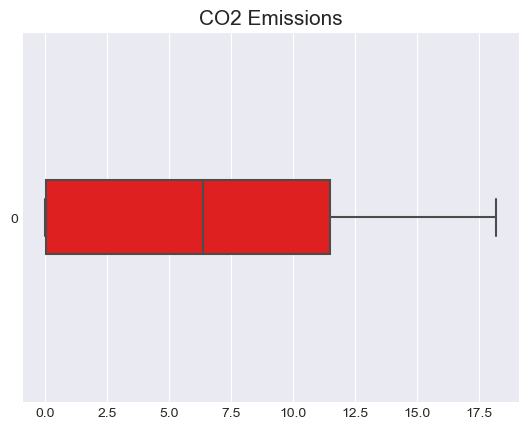

In [8]:
sns.boxplot(data=co2["CO2"], color='red', orient = 'h', width = 0.2)
plt.title('CO2 Emissions', fontsize=15)

In [9]:
df = co2.copy()
df.reset_index(inplace=True)

In [10]:
df['year_group'] = pd.cut(df['Year'], bins=5, labels=['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5'])
def get_year_range(group):
    min_year = group['Year'].min().strftime('%Y')
    max_year = group['Year'].max().strftime('%Y')
    return f'{min_year}-{max_year}'

In [11]:
year_labels = df.groupby('year_group').apply(get_year_range)

[Text(0, 0, '1800-1842'),
 Text(1, 0, '1843-1885'),
 Text(2, 0, '1886-1928'),
 Text(3, 0, '1929-1971'),
 Text(4, 0, '1972-2014')]

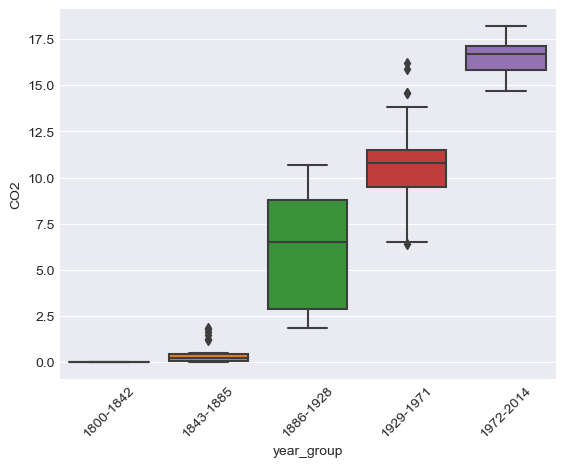

In [12]:
sns.boxplot(x='year_group', y='CO2', data=df).set_xticklabels(year_labels, rotation=45)

CO2 Range according to Years

In [13]:
co2.isnull().sum()

CO2    0
dtype: int64

In [14]:
co2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 1800-01-01 to 2014-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     215 non-null    float64
dtypes: float64(1)
memory usage: 11.5 KB


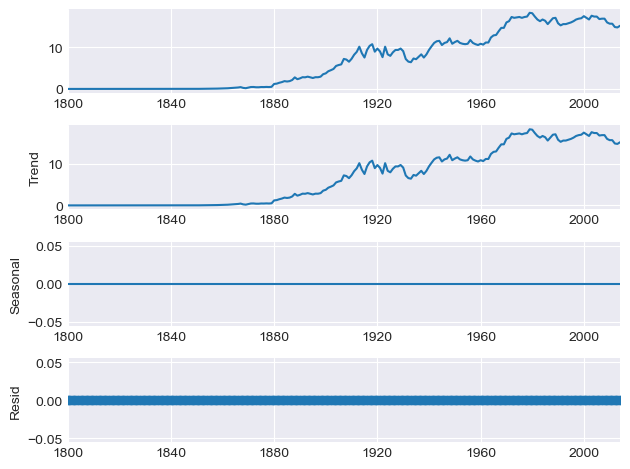

In [15]:
decompose_ts_add = seasonal_decompose(co2)
decompose_ts_add.plot()
plt.show()

As we can see the seasonality cannot be captured from the given data we are gonna built model keeping this in mind

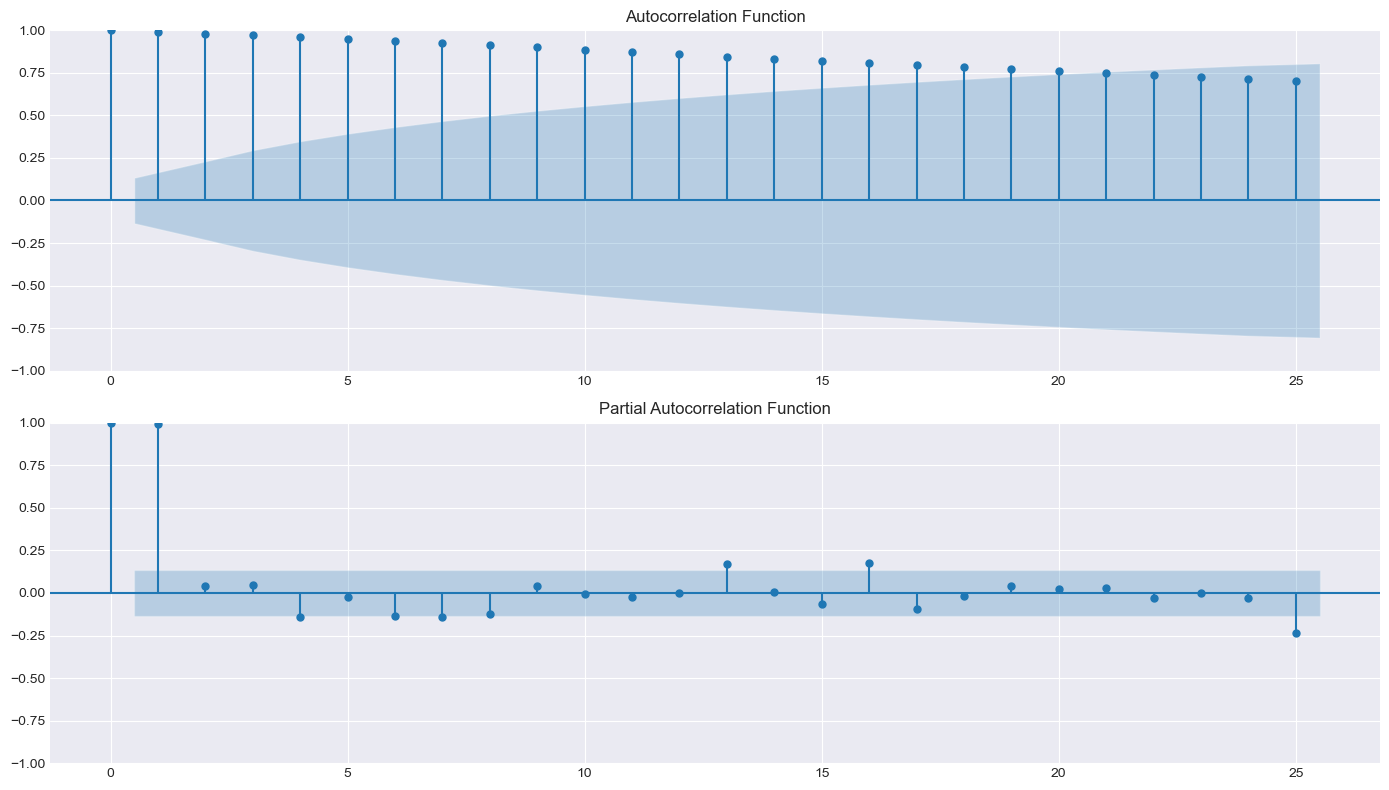

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))

plot_acf(co2.CO2, lags=25, alpha=0.05, ax=ax[0])
ax[0].set_title('Autocorrelation Function')

plot_pacf(co2.CO2, lags=25, alpha=0.05, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

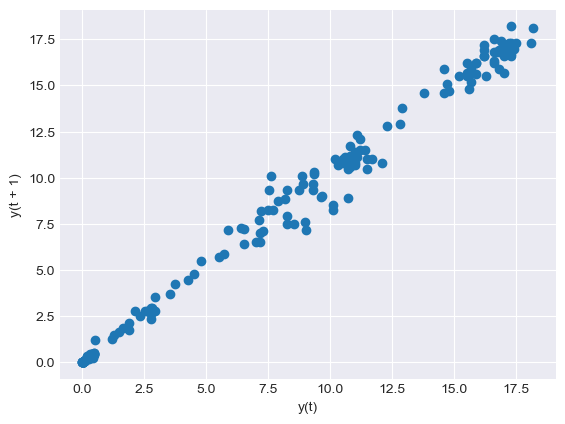

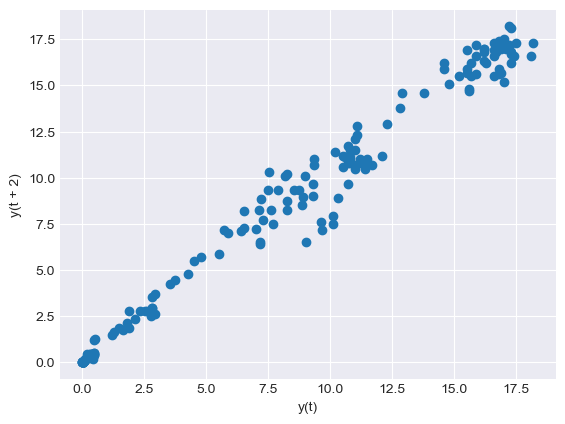

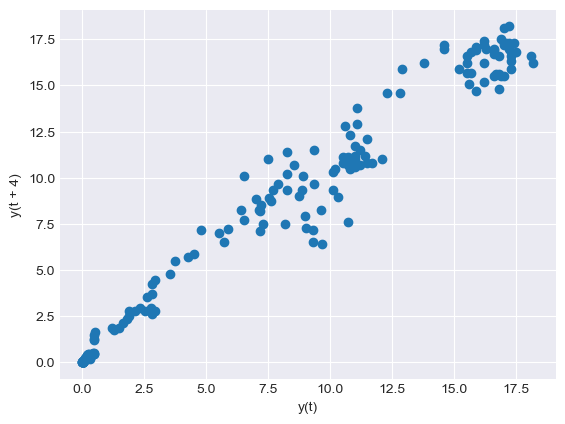

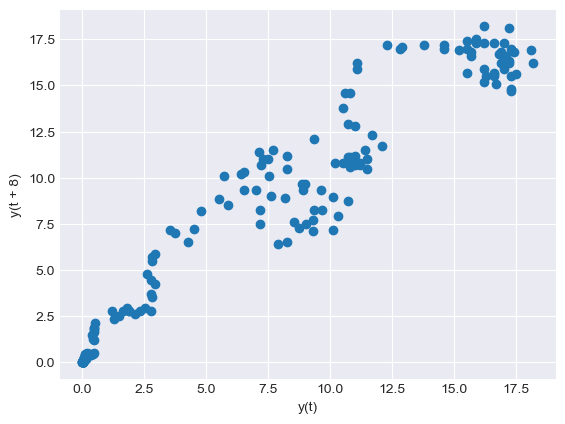

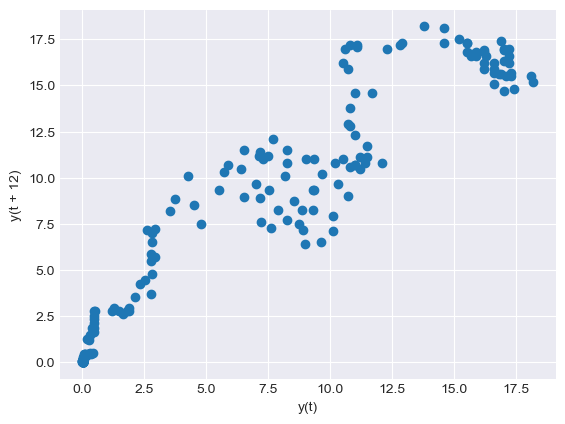

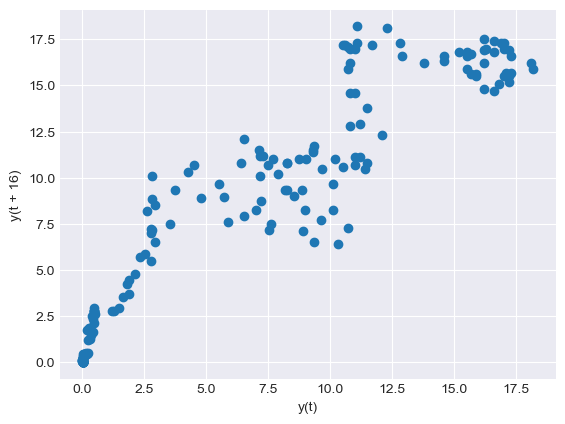

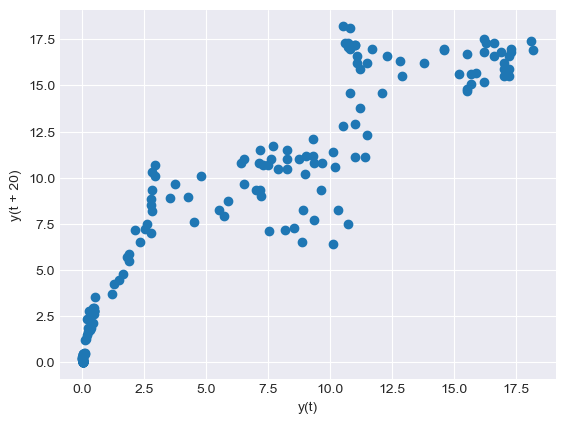

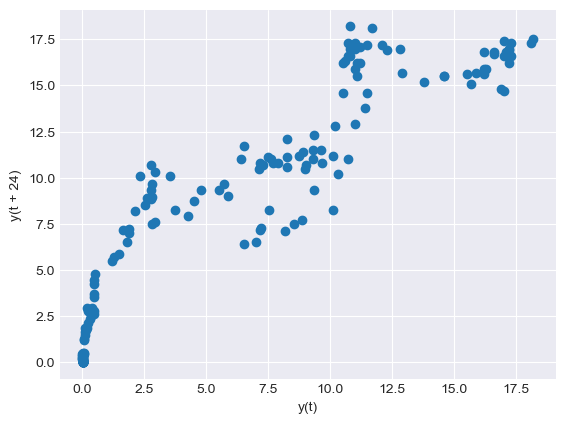

In [17]:
for i in [1, 2, 4, 8, 12, 16, 20, 24]:
    lag_plot(co2.CO2, lag=i)
    plt.show() 

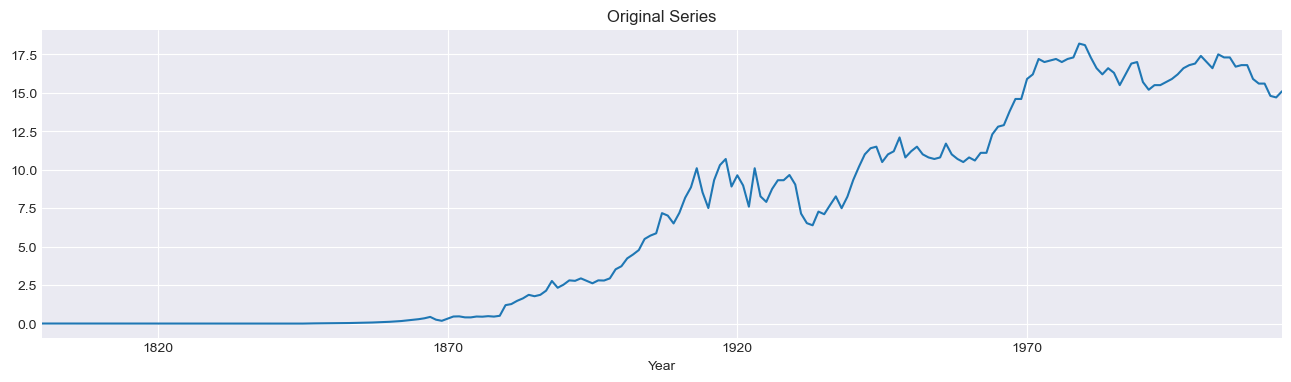

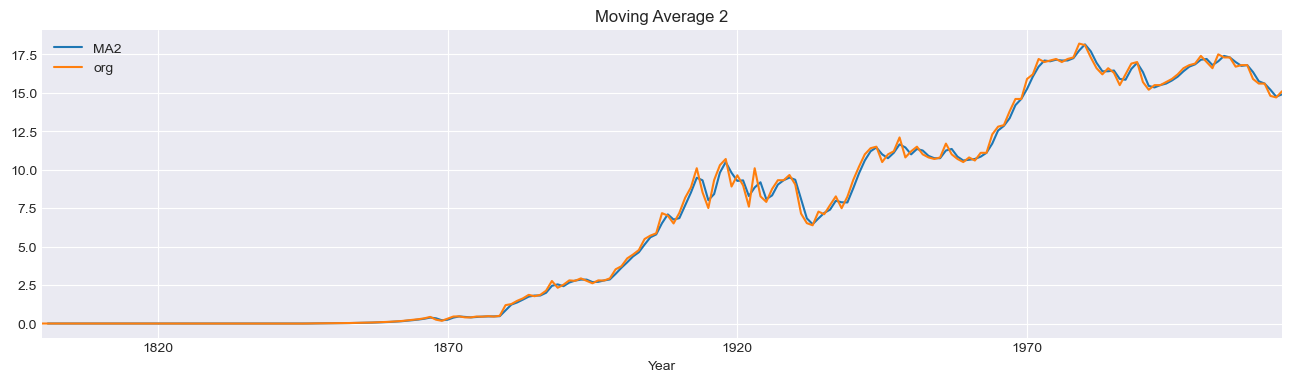

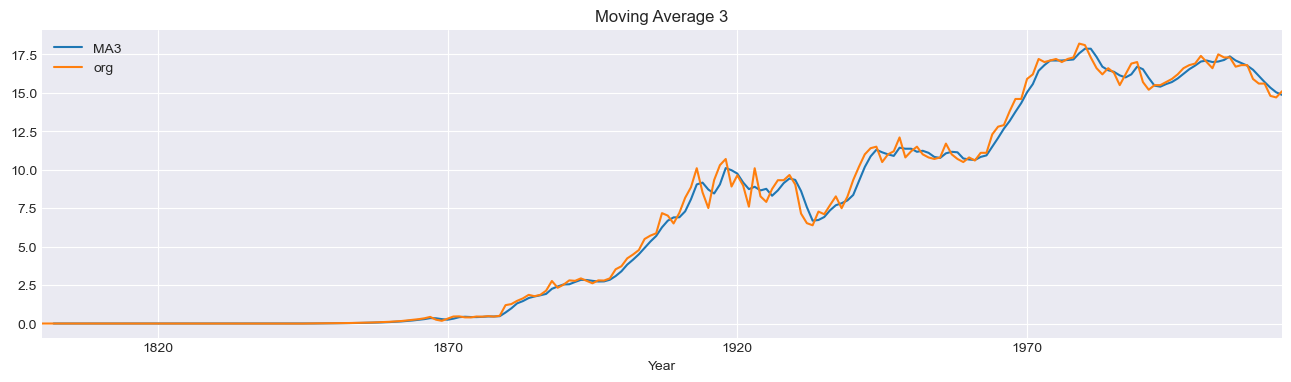

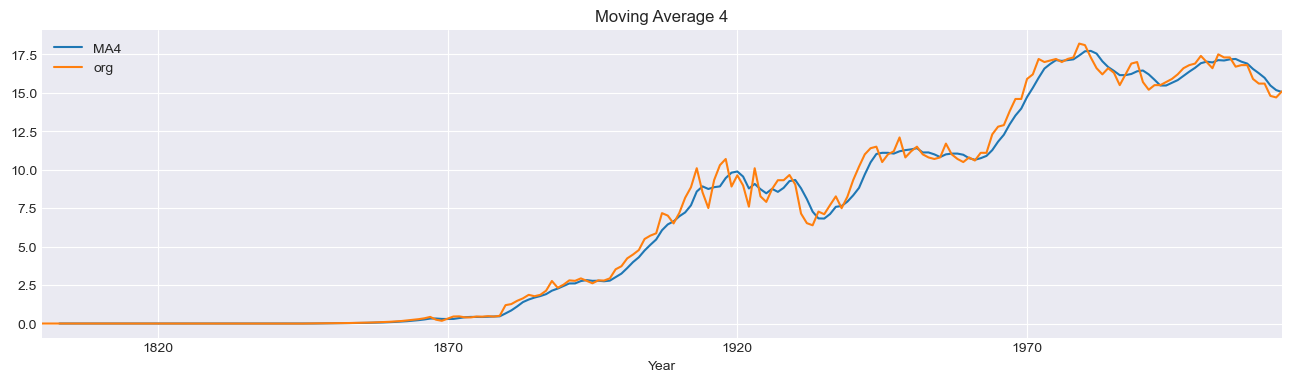

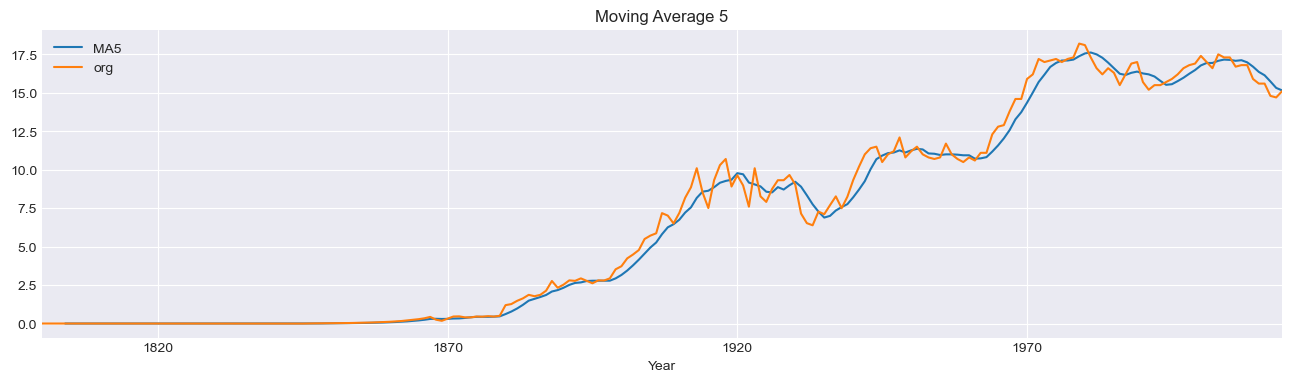

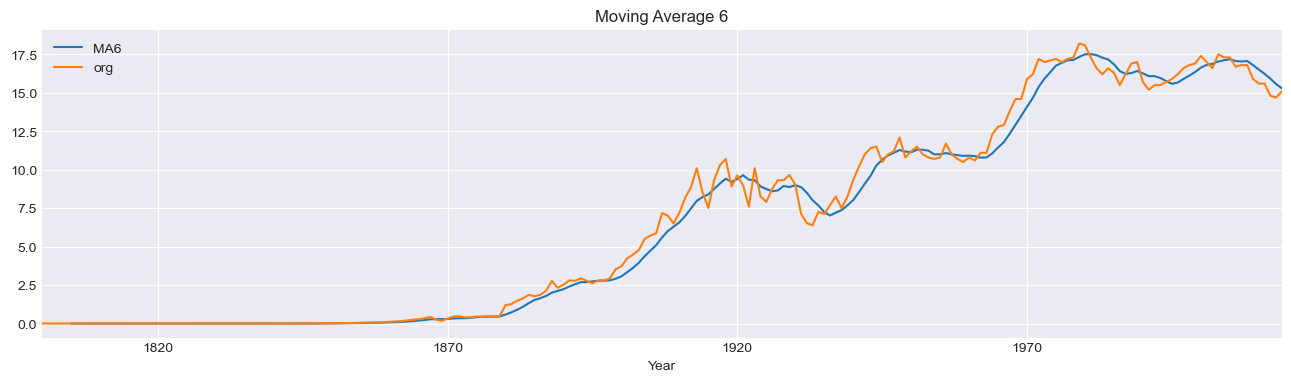

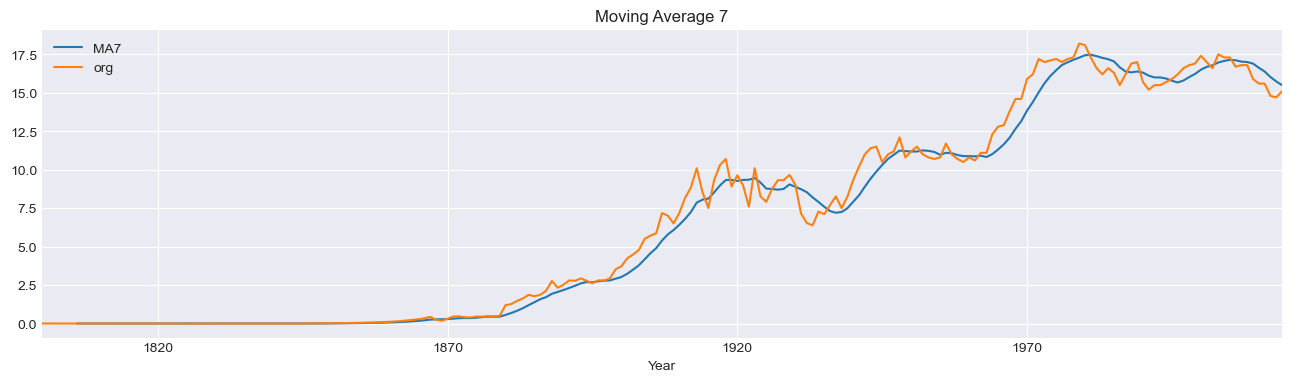

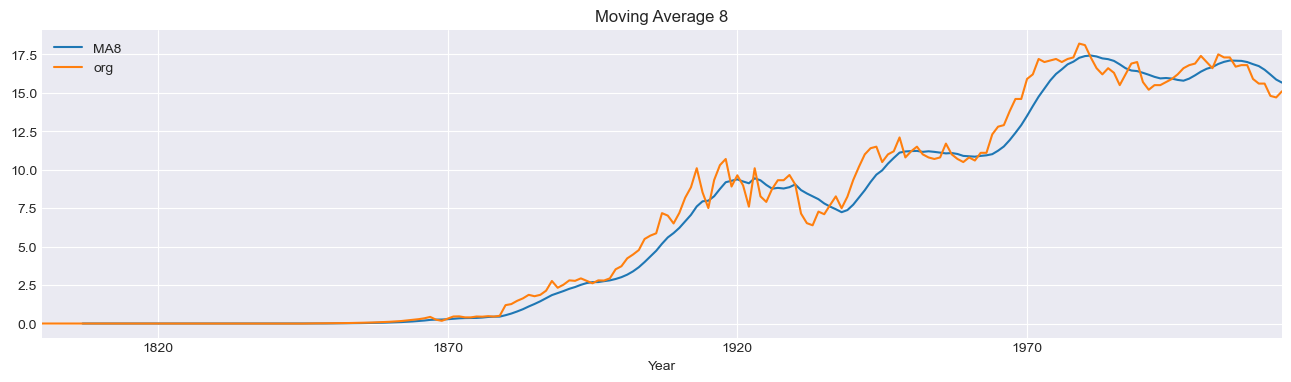

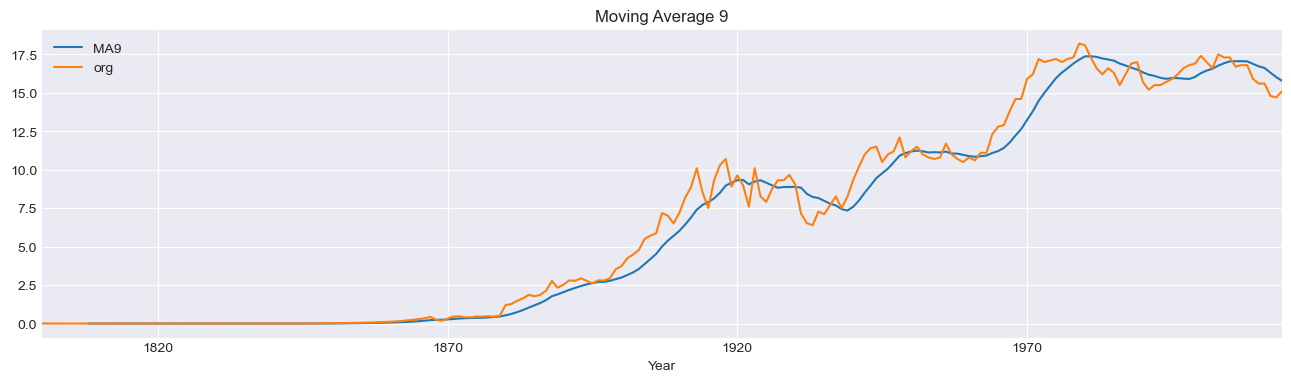

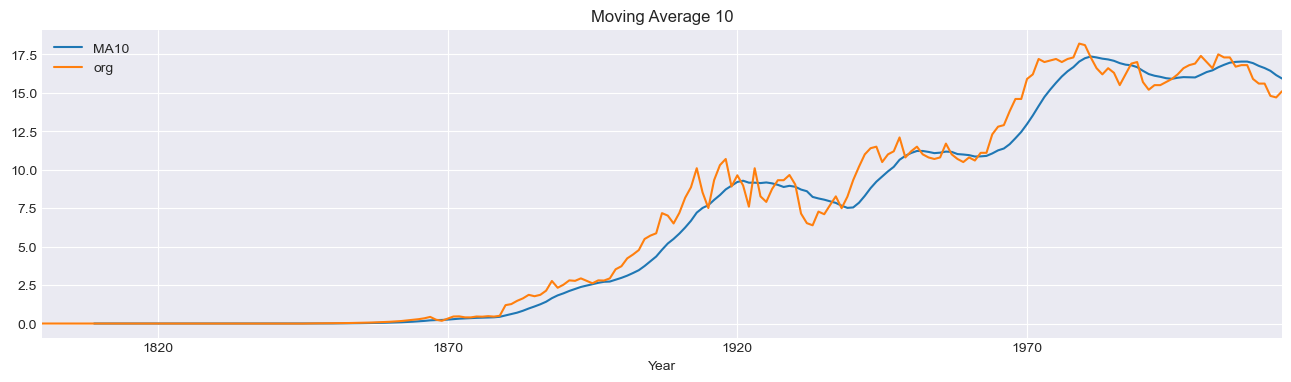

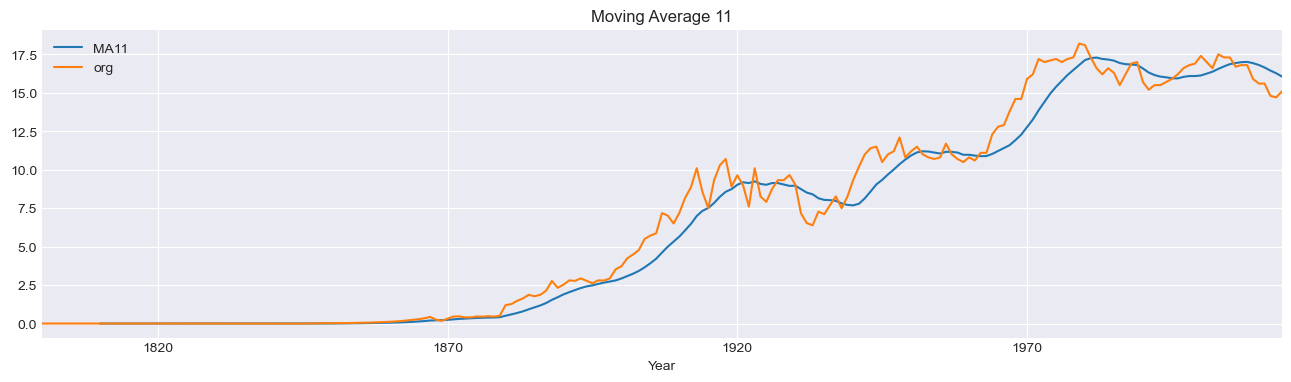

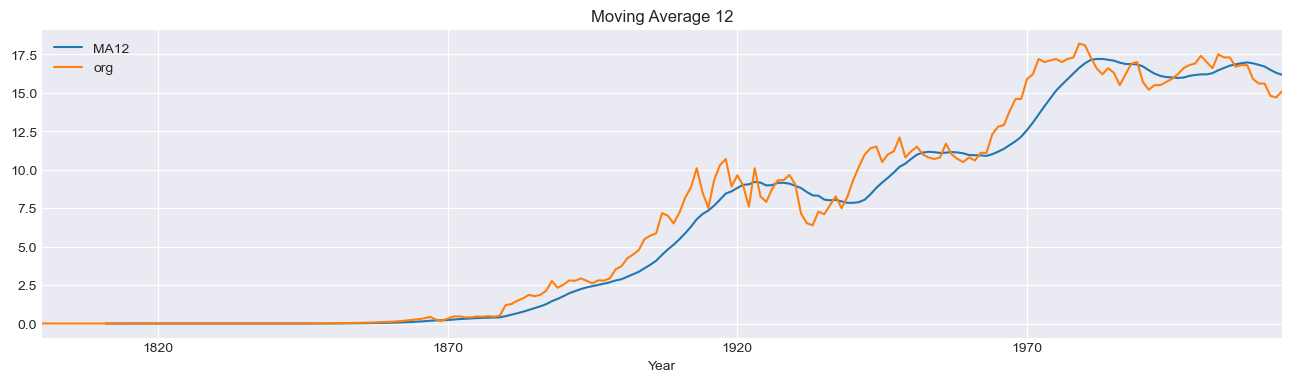

In [18]:
plt.figure(figsize=(16,4))
co2.CO2.plot(label="org")
plt.title("Original Series")

for i in range(2,13):
    plt.figure(figsize=(16,4))
    co2["CO2"].rolling(i).mean().plot(label="MA"+str(i))
    co2.CO2.plot(label="org")
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

In [19]:
co2Arima = co2.copy()

In [20]:
co2['t'] = np.arange(1,len(co2)+1)
co2['t_squared'] = np.square(co2.t)
co2['log_CO2'] = np.log(co2.CO2) 

In [21]:
co2

,CO2,t,t_squared,log_CO2
Year,,,,
1800-01-01,0.00568,1,1,-5.170804
1801-01-01,0.00561,2,4,-5.183205
1802-01-01,0.00555,3,9,-5.193957
1803-01-01,0.00548,4,16,-5.206650
1804-01-01,0.00542,5,25,-5.217659
...,...,...,...,...
2010-01-01,15.60000,211,44521,2.747271
2011-01-01,15.60000,212,44944,2.747271
2012-01-01,14.80000,213,45369,2.694627


In [22]:
Train = co2.loc[:'2000-01-01']
Test = co2.loc['2000-01-01':]

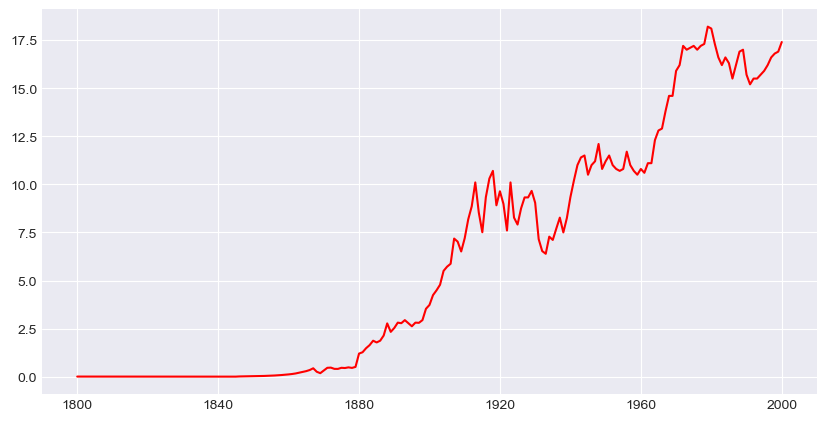

In [23]:
plt.figure(figsize=(10,5))
plt.plot(Train.CO2, color='red')

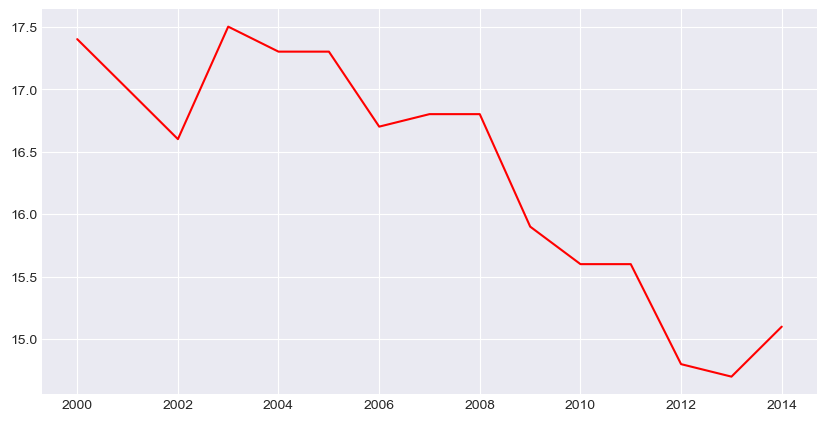

In [24]:
plt.figure(figsize=(10,5))
plt.plot(Test.CO2, color='red')

In [25]:
df_shifted = co2['CO2'].shift(1).fillna(df.iloc[0]['CO2'])
df_merged = pd.merge(df, df_shifted, on='Year', suffixes=('', '_previous'))
baseline_rmse = sqrt(mean_squared_error(df_merged['CO2'], df_merged['CO2_previous']))

In [26]:
baseline_rmse

0.5507790426963325

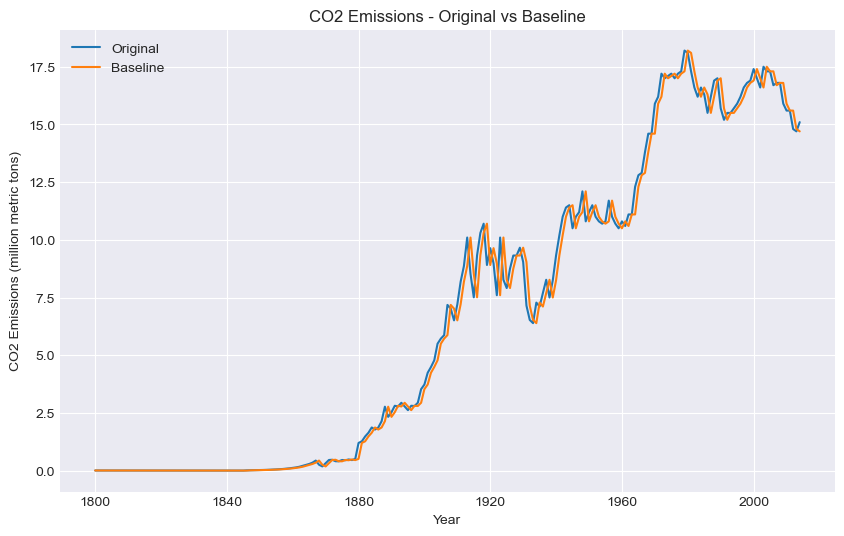

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(co2.index, co2['CO2'], label='Original')
plt.plot(co2.index, df_merged['CO2_previous'], label='Baseline')
plt.legend(loc='best')
plt.title('CO2 Emissions - Original vs Baseline')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.show()

In [28]:
linear_model = smf.ols('CO2~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['CO2'])-np.array(pred_linear))**2))
rmse_linear 

1.4480878541200697

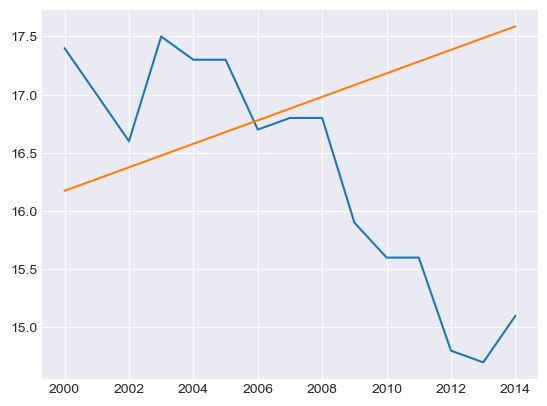

In [29]:
plt.plot(Test.CO2)
plt.plot(pred_linear)

In [30]:
Exp = smf.ols('log_CO2~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['CO2'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp 

194.27224289777325

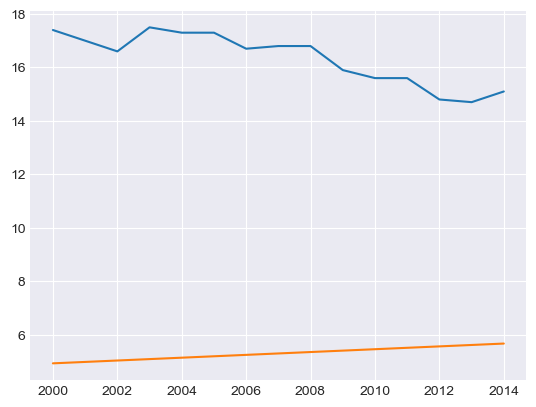

In [31]:
plt.plot(Test.CO2)
plt.plot(pred_Exp)

In [32]:
Quad = smf.ols('CO2~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['CO2'])-np.array(pred_Quad))**2))
rmse_Quad

4.802893257467944

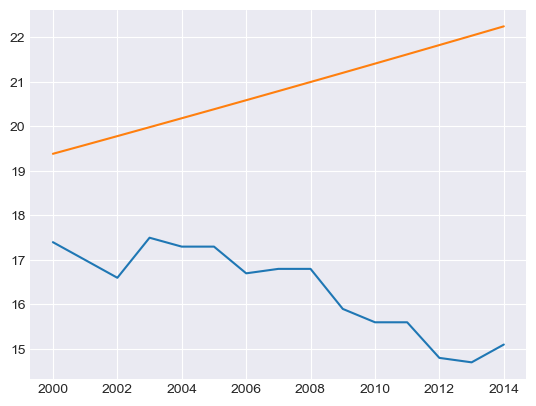

In [33]:
plt.plot(Test.CO2)
plt.plot(pred_Quad)

In [34]:
data = {"MODEL":pd.Series(["Baseline","Linear","Exp","Quad"]),"RMSE_Values":pd.Series([baseline_rmse,rmse_linear,rmse_Exp,rmse_Quad])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values']) 

,MODEL,RMSE_Values
0,Baseline,0.550779
1,Linear,1.448088
3,Quad,4.802893
2,Exp,194.272243


In [35]:
def rmse(actual, pred):
    mse = sklearn.metrics.mean_squared_error(actual, pred)  
    rmse = math.sqrt(mse)
    return rmse 

In [36]:
ses_model = SimpleExpSmoothing(Train["CO2"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses = rmse(Test.CO2, pred_ses) 
rmse_ses 

E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


0.9808010849059106

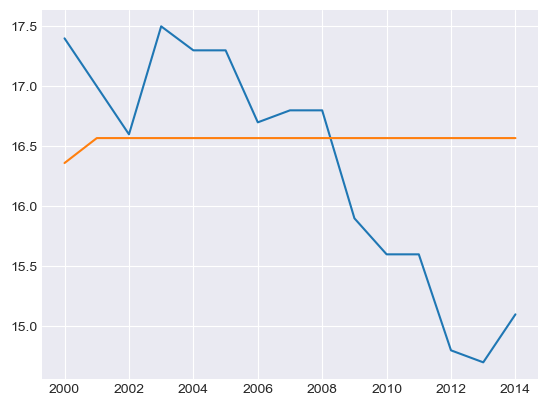

In [37]:
plt.plot(Test.CO2)
plt.plot(pred_ses)

In [38]:
hw_model = Holt(Train["CO2"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw = rmse(Test.CO2, pred_hw) 
rmse_hw

E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


2.9642859097972427

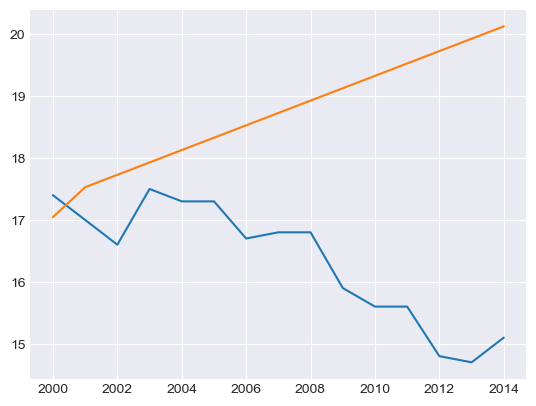

In [39]:
plt.plot(Test.CO2)
plt.plot(pred_hw)

In [40]:
data = {"MODEL":pd.Series(["Baseline","Linear","Exp","Quad","SES","Holt's"]),"RMSE_Values":pd.Series([baseline_rmse,rmse_linear,rmse_Exp,rmse_Quad,rmse_ses,rmse_hw])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values']) 

,MODEL,RMSE_Values
0,Baseline,0.550779
4,SES,0.980801
1,Linear,1.448088
5,Holt's,2.964286
3,Quad,4.802893
2,Exp,194.272243


Before proceeding to the Arima model we need to make sure that the data is stationary

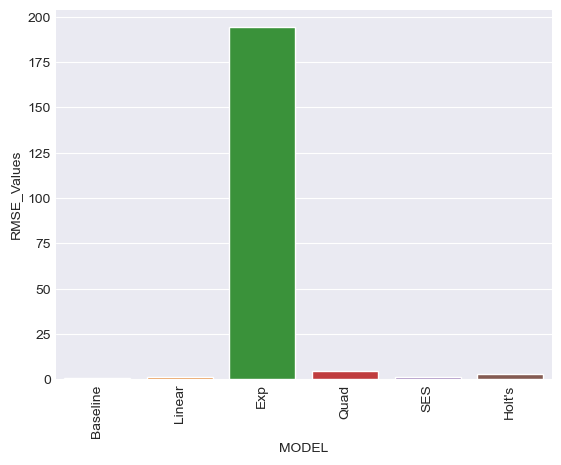

In [41]:
sns.barplot(table_rmse.MODEL , table_rmse.RMSE_Values)
plt.xticks(rotation = 90)
plt.show()

In [42]:
result = adfuller(co2Arima['CO2'])

In [43]:
p_value = result[1]
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')   
if p_value < 0.05:
    print('The dataset is stationary')
else:
    print('The dataset is not stationary')

ADF Statistic: -0.3784627751558865
p-value: 0.9136330950336238
Critical Values:
   1%: -3.4612821203214907
   5%: -2.875142613826617
   10%: -2.574020122281422
The dataset is not stationary


Using differencing method to make the data stationary

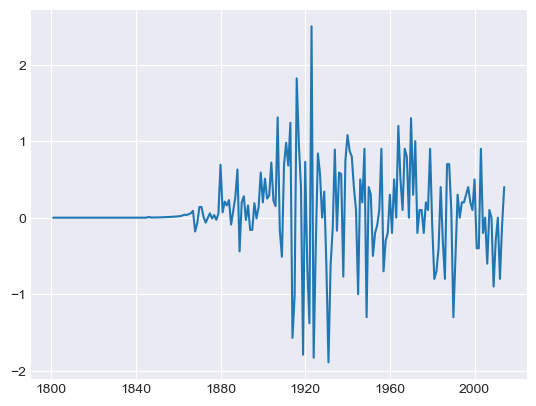

In [44]:
co2Arima['First_Difference'] = co2Arima['CO2'] - co2Arima['CO2'].shift(1)
plt.plot(co2Arima['First_Difference'])

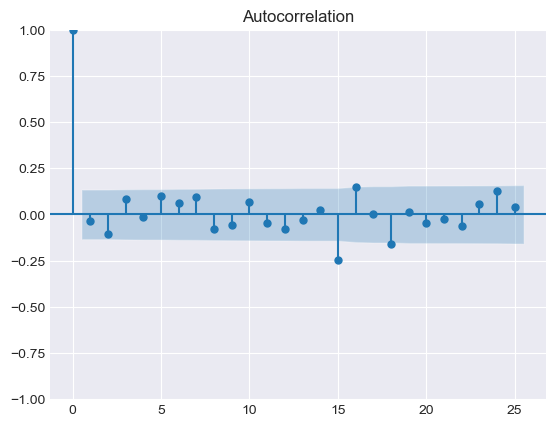

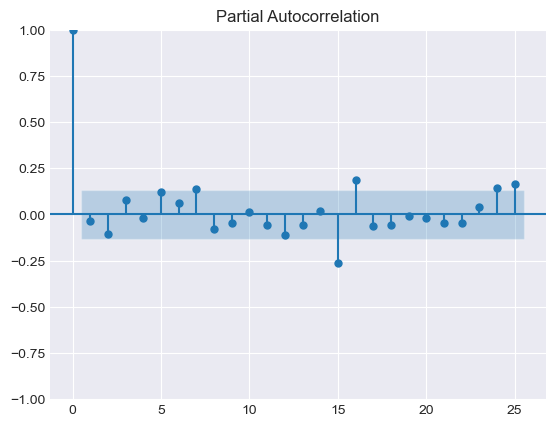

In [45]:
plot_acf(co2Arima['First_Difference'].dropna(),lags=25)
plot_pacf(co2Arima['First_Difference'].dropna(),lags=25)
plt.show()

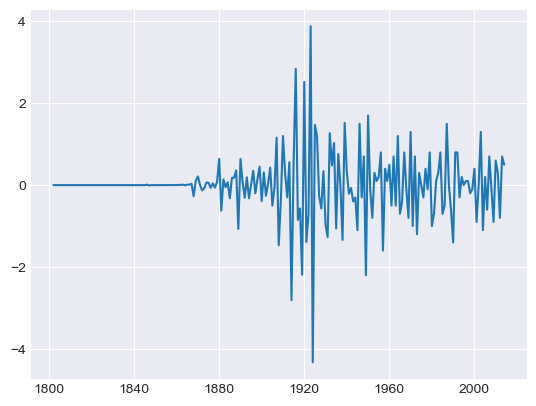

In [46]:
co2Arima['Second_Difference'] = co2Arima['CO2'] - 2*co2Arima['CO2'].shift(1) + co2Arima['CO2'].shift(2)
plt.plot(co2Arima['Second_Difference'])

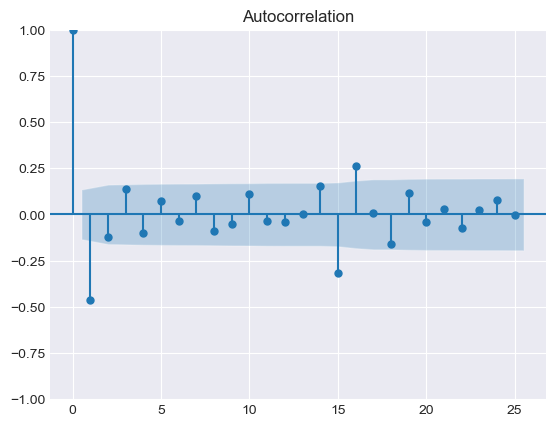

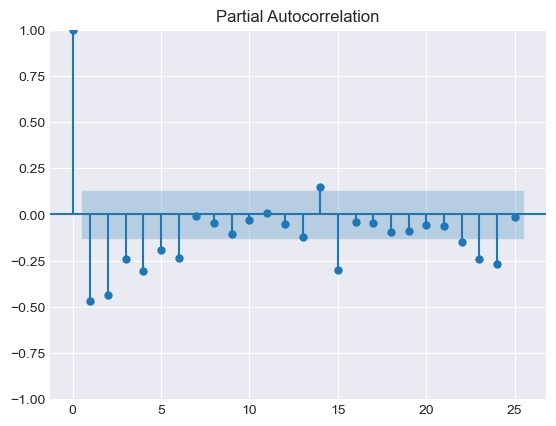

In [47]:
plot_acf(co2Arima['Second_Difference'].dropna(),lags=25)
plot_pacf(co2Arima['Second_Difference'].dropna(),lags=25)
plt.show()

In [48]:
result_1 = adfuller(co2Arima['First_Difference'].dropna())

In [49]:
p_value = result_1[1]
print(f'ADF Statistic: {result_1[0]}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in result_1[4].items():
    print(f'   {key}: {value}')   
if p_value < 0.05:
    print('The dataset is stationary')
else:
    print('The dataset is not stationary')

ADF Statistic: -3.78000453058425
p-value: 0.003118649594242052
Critical Values:
   1%: -3.4638151713286316
   5%: -2.876250632135043
   10%: -2.574611347821651
The dataset is stationary


In [50]:
result_2 = adfuller(co2Arima['Second_Difference'].dropna())

In [51]:
p_value = result_2[1]
print(f'ADF Statistic: {result_2[0]}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in result_2[4].items():
    print(f'   {key}: {value}')   
if p_value < 0.05:
    print('The dataset is stationary')
else:
    print('The dataset is not stationary')

ADF Statistic: -5.53608120881544
p-value: 1.743526276212014e-06
Critical Values:
   1%: -3.4638151713286316
   5%: -2.876250632135043
   10%: -2.574611347821651
The dataset is stationary


In [52]:
co2Arima

,CO2,First_Difference,Second_Difference
Year,,,
1800-01-01,0.00568,NaN,NaN
1801-01-01,0.00561,-0.00007,NaN
1802-01-01,0.00555,-0.00006,0.00001
1803-01-01,0.00548,-0.00007,-0.00001
1804-01-01,0.00542,-0.00006,0.00001
...,...,...,...
2010-01-01,15.60000,-0.30000,0.60000
2011-01-01,15.60000,0.00000,0.30000
2012-01-01,14.80000,-0.80000,-0.80000


RMSE: 0.7028513356322228


E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


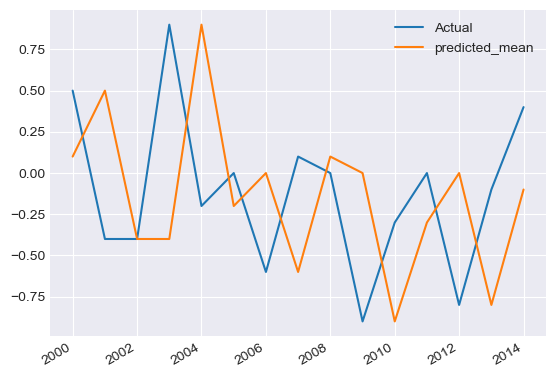

In [53]:
arima1 = ARIMA(co2Arima.loc[:,'First_Difference'], order=(0,1,0))
results1 = arima1.fit()
predictions1 = results1.predict('2000-01-01', '2014-01-01')

plt.plot(co2Arima.loc['2000-01-01':,'First_Difference'],label='Actual')
predictions1.plot()
plt.legend();

print('RMSE:',np.sqrt(mean_squared_error(co2Arima.loc['2000-01-01':,'First_Difference'],predictions1)))

E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


RMSE: 0.49510745980088844


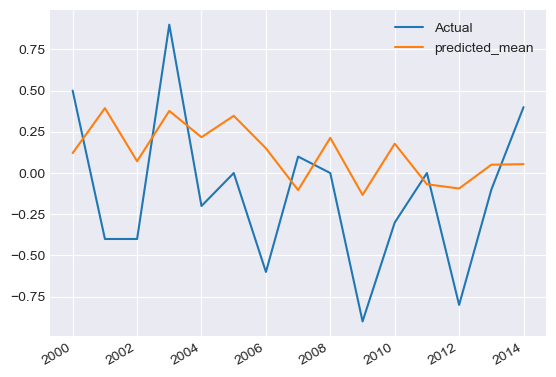

In [54]:
arima2 = ARIMA(co2Arima.loc[:,'First_Difference'], order=(15,1,2))
results2 = arima2.fit()
predictions2 = results2.predict('2000-01-01', '2014-01-01')

plt.plot(co2Arima.loc['2000-01-01':,'First_Difference'],label='Actual')
predictions2.plot()
plt.legend();

print('RMSE:',np.sqrt(mean_squared_error(co2Arima.loc['2000-01-01':,'First_Difference'],predictions2)))

E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 0.4793471781513226


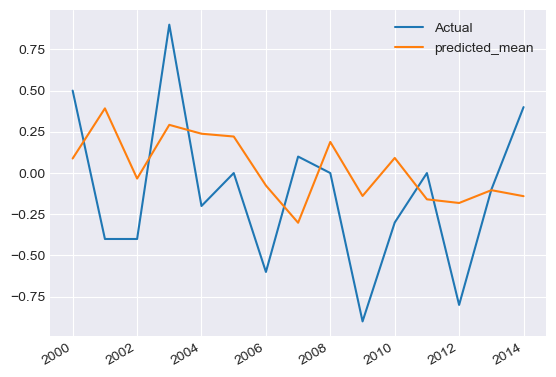

In [55]:
arima3 = ARIMA(co2Arima.loc[:,'First_Difference'], order=(15,2,2))
results3 = arima3.fit()
predictions3 = results3.predict('2000-01-01', '2014-01-01')

plt.plot(co2Arima.loc['2000-01-01':,'First_Difference'],label='Actual')
predictions3.plot()
plt.legend();
rmse_arima = np.sqrt(mean_squared_error(co2Arima.loc['2000-01-01':,'First_Difference'],predictions3))

print('RMSE:',np.sqrt(mean_squared_error(co2Arima.loc['2000-01-01':,'First_Difference'],predictions3)))

E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 0.4789925748036387


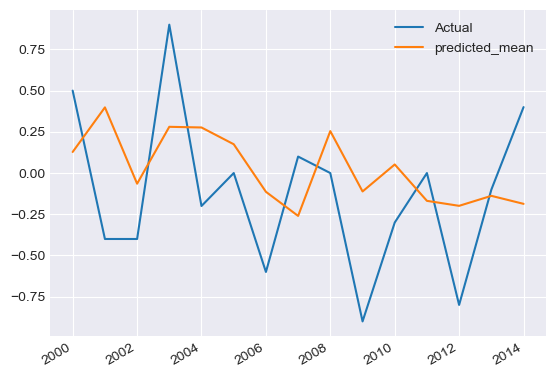

In [56]:
arima4 = ARIMA(co2Arima.loc[:,'First_Difference'], order=(15,2,3))
results4 = arima4.fit()
predictions4 = results4.predict('2000-01-01', '2014-01-01')

plt.plot(co2Arima.loc['2000-01-01':,'First_Difference'],label='Actual')
predictions4.plot()
plt.legend();

print('RMSE:',np.sqrt(mean_squared_error(co2Arima.loc['2000-01-01':,'First_Difference'],predictions4)))

In [57]:
data = {"MODEL":pd.Series(["Baseline","Linear","Exp","Quad","SES","Holt's","Arima"]),"RMSE_Values":pd.Series([baseline_rmse,rmse_linear,rmse_Exp,rmse_Quad,rmse_ses,rmse_hw,rmse_arima])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values']) 

,MODEL,RMSE_Values
6,Arima,0.479347
0,Baseline,0.550779
4,SES,0.980801
1,Linear,1.448088
5,Holt's,2.964286
3,Quad,4.802893
2,Exp,194.272243


Selecting final model as ARIMA with order:15,2,3.

Combining train and test and doing the prediction

In [58]:
co2Arima

,CO2,First_Difference,Second_Difference
Year,,,
1800-01-01,0.00568,NaN,NaN
1801-01-01,0.00561,-0.00007,NaN
1802-01-01,0.00555,-0.00006,0.00001
1803-01-01,0.00548,-0.00007,-0.00001
1804-01-01,0.00542,-0.00006,0.00001
...,...,...,...
2010-01-01,15.60000,-0.30000,0.60000
2011-01-01,15.60000,0.00000,0.30000
2012-01-01,14.80000,-0.80000,-0.80000


E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 0.5009490454772751


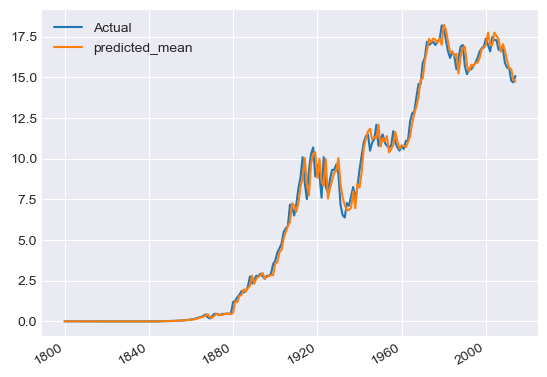

In [59]:
Final = ARIMA(co2Arima.loc[:,'CO2'], order=(15,2,3))
results5 = Final.fit()
predictions5 = results5.predict('1800-01-01', '2014-01-01')

plt.plot(co2Arima.loc['1800-01-01':,'CO2'],label='Actual')
predictions5.plot()
plt.legend();

rmse_arima = np.sqrt(mean_squared_error(co2Arima.loc['1800-01-01':,'CO2'],predictions5))

print('RMSE:',np.sqrt(mean_squared_error(co2Arima.loc['1800-01-01':,'CO2'],predictions5)))

In [60]:
data = {"MODEL":pd.Series(["Baseline","Linear","Exp","Quad","SES","Holt's","Arima"]),"RMSE_Values":pd.Series([baseline_rmse,rmse_linear,rmse_Exp,rmse_Quad,rmse_ses,rmse_hw,rmse_arima])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values']) 

,MODEL,RMSE_Values
6,Arima,0.500949
0,Baseline,0.550779
4,SES,0.980801
1,Linear,1.448088
5,Holt's,2.964286
3,Quad,4.802893
2,Exp,194.272243


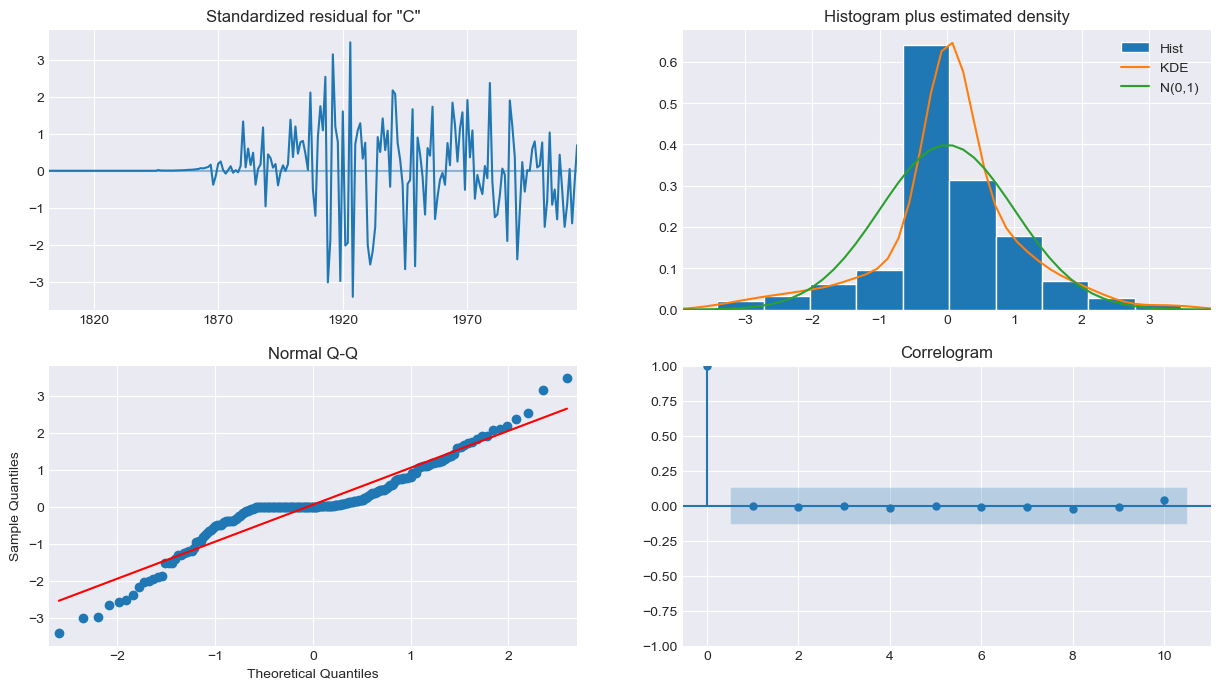

In [61]:
results5.plot_diagnostics(figsize=(15, 8))
plt.show()

In [62]:
results5.forecast(steps=15)

2015-01-01    14.913903
2016-01-01    14.880228
2017-01-01    14.979492
2018-01-01    14.777580
2019-01-01    15.048416
2020-01-01    15.145013
2021-01-01    15.457759
2022-01-01    15.525128
2023-01-01    15.608648
2024-01-01    16.054099
2025-01-01    16.086284
2026-01-01    16.160054
2027-01-01    16.521429
2028-01-01    16.526869
2029-01-01    16.570569
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [63]:
forecast = results5.forecast(steps=15)

In [64]:
forecast

2015-01-01    14.913903
2016-01-01    14.880228
2017-01-01    14.979492
2018-01-01    14.777580
2019-01-01    15.048416
2020-01-01    15.145013
2021-01-01    15.457759
2022-01-01    15.525128
2023-01-01    15.608648
2024-01-01    16.054099
2025-01-01    16.086284
2026-01-01    16.160054
2027-01-01    16.521429
2028-01-01    16.526869
2029-01-01    16.570569
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [65]:
with open('arima_results.pkl', 'wb') as f:
    pickle.dump(results5, f)

In [66]:
with open('arima_results.pkl', 'rb') as f:
    results5 = pickle.load(f)

In [67]:
future_dates = pd.date_range(start='2014-01-01', end='2029-01-01', freq='AS')
predictions_future = results5.predict(start='2014-01-01', end='2029-01-01')

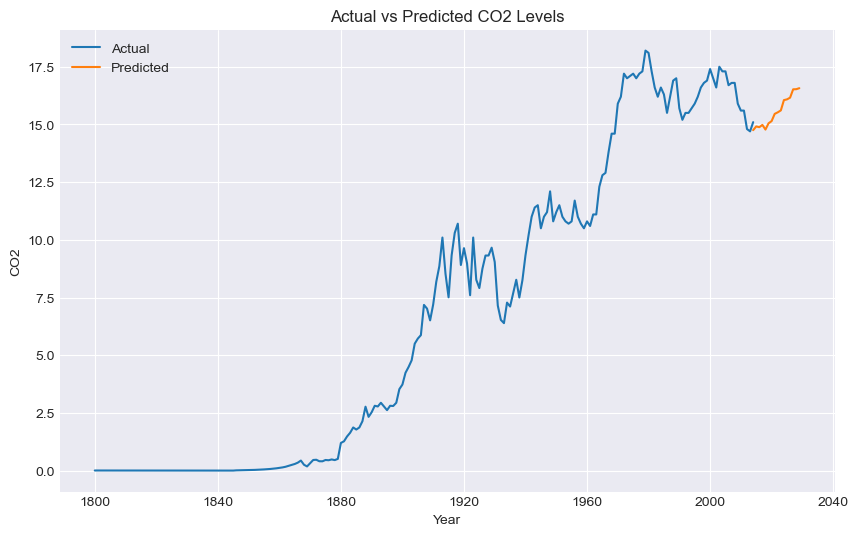

In [68]:
plt.figure(figsize=(10,6))
plt.plot(co2Arima.loc['1800-01-01':,'CO2'], label='Actual')
plt.plot(predictions_future, label='Predicted')
plt.xlabel('Year')
plt.ylabel('CO2')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()